In [1]:
import numpy as np
import pandas as pd
from star_network.StarNode import StarNode
from ring_network.RingNode import RingNode
from controller_worker.Controller import Controller
from sharding_methods.EvenSplit import even_split
from sharding_methods.Predicate import predicate_split
from sharding_methods.OurMethod import our_split
from util.predicates import predicate_interval
import matplotlib.pyplot as plt
import time
import random

In [2]:
# Constants for simulation
NUM_QUERIES = 100
COLUMN = 'rating'
PRED_CHOICES = ['LT', 'LE', 'GT', 'GE']
VALUE_RANGE = [0, 10]

In [3]:
# Load data
df: pd.DataFrame = pd.read_csv('./data/stats_df.csv')
stats: np.ndarray = np.load('./data/stats.npy')

NUM_SHARDS = stats.shape[1]
NUM_ROWS = len(df)

In [4]:
# Setup different splt types
even_split_dfs = even_split(df, NUM_SHARDS)
pred_intervals = predicate_interval(VALUE_RANGE, NUM_SHARDS)
pred_split_dfs = predicate_split(df, COLUMN,  pred_intervals)
# our_split_dfs = our_split(df, stats)

In [5]:
# Setup Controller Worker
cw_even = Controller(even_split_dfs)
cw_pred = Controller(pred_split_dfs, predicates=pred_intervals)
# cw_our = Controller(our_split_dfs)

In [6]:
# Setup Ring-Even Network
ring_even = []
for i in range(NUM_SHARDS):
    new_node = RingNode(i, NUM_SHARDS, even_split_dfs[i])
    ring_even.append(new_node)

for i in range(0, len(ring_even) - 1):
    ring_even[i].set_link(ring_even[i+1])
ring_even[-1].set_link(ring_even[0])

In [7]:
#Setup Ring-Pred Network
ring_pred = []
for i in range(NUM_SHARDS):
    new_node = RingNode(i, NUM_SHARDS, pred_split_dfs[i], interval=pred_intervals[i])
    ring_pred.append(new_node)

for i in range(0, len(ring_pred) - 1):
    ring_pred[i].set_link(ring_pred[i+1])
ring_pred[-1].set_link(ring_pred[0])

In [8]:
# Setup ring-our
# ring_our = []
# for i in range(NUM_SHARDS):
#     new_node = RingNode(i, NUM_SHARDS, our_split_dfs[i])
#     ring_our.append(new_node)

# for i in range(0, len(ring_our) - 1):
#     ring_our[i].set_link(ring_our[i+1])
# ring_our[-1].set_link(ring_our[0])

In [9]:
# Setup star-even

star_even = []
for i in range(NUM_SHARDS):
    new_node = StarNode(i, even_split_dfs[i])
    star_even.append(new_node)

for i in range(len(star_even)):
    others = star_even[:i] + star_even[i+1:]
    star_even[i].set_connections(others)

In [10]:
# Setup Star-pred
star_pred = []
for i in range(NUM_SHARDS):
    new_node = StarNode(i, pred_split_dfs[i], interval=pred_intervals[i])
    star_pred.append(new_node)

for i in range(len(star_pred )):
    others = star_pred[:i] + star_pred[i+1:]
    star_pred[i].set_connections(others)

In [11]:
# Setup Star-ours
# star_our = []
# for i in range(NUM_SHARDS):
#     new_node = StarNode(i, our_split_dfs[i])
#     star_our.append(new_node)

# for i in range(len(star_our)):
#     others = star_our[:i] + star_our[i+1:]
#     star_our[i].set_connections(others)

In [12]:
# X-axis for first set is just query fluctuation
x = np.arange(NUM_QUERIES)

In [13]:
y_cw_even = np.ndarray((NUM_QUERIES))
y_cw_pred = np.ndarray((NUM_QUERIES))
y_cw_our = np.ndarray((NUM_QUERIES))

y_ring_even = np.ndarray((NUM_QUERIES))
y_ring_pred = np.ndarray((NUM_QUERIES))
y_ring_our = np.ndarray((NUM_QUERIES))

y_star_even = np.ndarray((NUM_QUERIES))
y_star_pred = np.ndarray((NUM_QUERIES))
y_star_our = np.ndarray((NUM_QUERIES))

In [14]:
# Start threads for cw
cw_even.start_threads()
cw_pred.start_threads()
# cw_our.start_threads()

# Run queries and time them
for i in range(NUM_QUERIES):

    pred = random.choice(PRED_CHOICES)
    val = random.uniform(VALUE_RANGE[0], VALUE_RANGE[1])

    #Controller worker
    cw_query = (COLUMN, pred, val)
    #cw-even 
    start = time.time()
    cw_even.execute_query(cw_query)
    end = time.time()
    y_cw_even[i] = end-start

    #cw-pred
    start = time.time()
    cw_pred.execute_query(cw_query)
    end = time.time()
    y_cw_pred[i] = end-start

    #cw-our
    start = time.time()
    # cw_our.execute_query(cw_query)
    end = time.time()
    y_cw_our[i] = end-start

    #Ring Network sim
    #ring-even
    start = time.time()
    ring_even[0].query(COLUMN, pred, val)
    end = time.time()
    y_ring_even[i] = end-start
    #ring-pred
    start = time.time()
    ring_pred[0].query(COLUMN, pred, val)
    end = time.time()
    y_ring_pred[i] = end-start
    #ring-our
    start = time.time()
    # ring_our[0].query(COLUMN, pred, val)
    end = time.time()
    y_ring_our[i] = end-start

    #Star Network
    chosen_node = random.randint(0, NUM_SHARDS - 1)
    #star-even 
    start = time.time()
    star_even[chosen_node].query(COLUMN, pred, val)
    end = time.time()
    y_star_even[i] = end-start

    #star-pred
    start = time.time()
    star_pred[chosen_node].query(COLUMN, pred, val)
    end = time.time()
    y_star_pred = end-start

    #star-our
    start = time.time()
    # star_our[chosen_node].query(COLUMN, pred, val)
    end = time.time()
    y_star_our = end-start

cw_even.execute_query('done')
cw_pred.execute_query('done')
# cw_our.execute_query('done')

'Process ended'

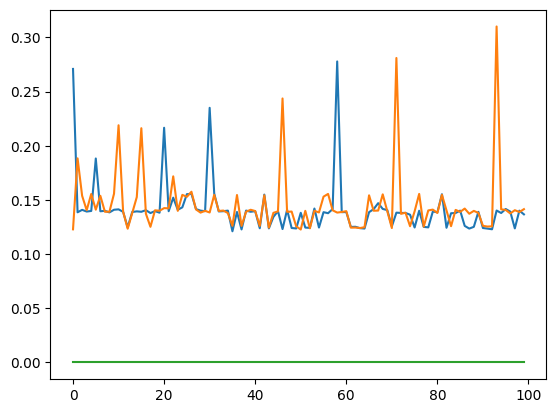

In [15]:
plt.plot(x, y_cw_even)
plt.plot(x, y_cw_pred)
plt.plot(x, y_cw_our)